Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.png)

# Training, hyperparameter tune, and deploy with Keras

## Introduction
This tutorial shows how to train a simple deep neural network using the MNIST dataset and Keras on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [configuration notebook](../../../configuration.ipynb) to:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)
* For local scoring test, you will also need to have `tensorflow` and `keras` installed in the current Jupyter kernel.

Let's get started. First let's import some Python libraries.

In [1]:
!pip install --upgrade azureml-sdk

Requirement already up-to-date: azureml-sdk in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.13.0)


In [17]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [18]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.13.0


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [19]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: mlserviceworkspace
Azure region: westus2
Subscription id: 601f4351-33bb-4d76-96ca-886940409b3d
Resource group: mlserviceworkspace


## Create an Azure ML experiment
Let's create an experiment named "keras-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [5]:
from azureml.core import Experiment

script_folder = './keras-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='keras-mnist-demo')

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

### Download the MNIST dataset

Download the MNIST dataset and save the files into a `data` directory locally.  Images and labels for both training and testing are downloaded.

In [22]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'test-labels.gz'))

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/cpucompute/code/Users/meranjit/train-hyperparameter-tune-deploy-with-keras/data/test-labels.gz',
 <http.client.HTTPMessage at 0x7f69a5c885f8>)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compressed files into numpy arrays.

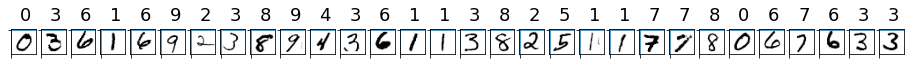

In [23]:
# make sure utils.py is in the same directory as this code
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the training set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

Now you have an idea of what these images look like and the expected prediction outcome.

## Create a FileDataset
A FileDataset references one or multiple files in your datastores or public urls. The files can be of any format. FileDataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [20]:
from azureml.core.dataset import Dataset

web_paths = [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]

dataset = Dataset.File.from_files(path = web_paths)

Use the `register()` method to register datasets to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.

In [9]:
dataset = dataset.register(workspace = ws,
                           name = 'mnist dataset',
                           description='training and test dataset',
                           create_new_version=True)

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [10]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 2, 'targetNodeCount': 2, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 2, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-09-02T09:07:39.507000+00:00', 'errors': None, 'creationTime': '2019-09-09T04:29:17.187921+00:00', 'modifiedTime': '2020-09-02T09:10:10.207131+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 2, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT10S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named "gpu-cluster" of type `AmlCompute`.

In [11]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

akscompute AKS Succeeded
cpue8v3aks AKS Succeeded
gpunc6aks AKS Succeeded
gpunv6aks AKS Succeeded
akscpucompute AKS Succeeded
gpucluster AmlCompute Succeeded
cpucluster AmlCompute Succeeded
cpucompute ComputeInstance Succeeded


## Copy the training files into the script folder
The Keras training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [12]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./keras_mnist.py', script_folder)
shutil.copy('./keras_mnist_horovod.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./keras-mnist/utils.py'

## Construct neural network in Keras
In the training script `keras_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

![DNN](nn.png)

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the FileDataset in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the loss and accuracy at the end of each epoch via callback.
```
    run.log('Loss', log['loss'])
    run.log('Accuracy', log['acc'])
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect.

In [13]:
with open(os.path.join(script_folder, './keras_mnist_horovod.py'), 'r') as f:
    print(f.read())

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import argparse
import os
import glob

import matplotlib.pyplot as plt
import tensorflow as tf
import horovod.tensorflow.keras as hvd

from azureml.core import Run
from utils import load_data, one_hot_encode

print("Keras version:", tf.keras.__version__)


# Horovod: initialize Horovod.
hvd.init()

# Horovod: pin GPU to be used to process local rank (one GPU per process)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')


parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neuro

## Create Estimator for Distributed Training

In [14]:
from azureml.core.dataset import Dataset
dataset = Dataset.get_by_name(ws, 'mnist dataset')

# list the files referenced by mnist dataset
dataset.to_path()

['/http%3A/%2Fyann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
 '/http%3A/%2Fyann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
 '/http%3A/%2Fyann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
 '/http%3A/%2Fyann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

In [15]:
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration

script_params = {
    '--data-folder': dataset.as_named_input('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.001
}

est = Estimator(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 node_count=2,
                 process_count_per_node=1,
                 distributed_training=MpiConfiguration(),
                 use_gpu=True,
                 entry_script='keras_mnist_horovod.py', 
                 pip_packages=['mxnet','torch','tensorflow==1.15','keras==2.2.5','matplotlib','horovod==0.16.1'])

## Submit job to run
Submit the estimator to the Azure ML experiment to kick off the execution.

In [16]:
run = exp.submit(est)

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [17]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [ ]:
run.wait_for_completion(show_output=True)

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [18]:
run.get_metrics()

{'Loss': [0.1680586942033066,
  0.06115206699613433,
  0.0456900907206394,
  0.03549830674208844,
  0.02609661271779565,
  0.01896686824046971,
  0.017768173733816596,
  0.014119597590800129,
  0.012938060941291855,
  0.011884379448918242,
  0.010593054415836328,
  0.00935288261631246,
  0.009177690457898492,
  0.007673402219830509,
  0.01020280792264482,
  0.007924824788963725,
  0.008777197601794781,
  0.007434093571996439,
  0.007446444791939792,
  0.007572522071621098],
 'Accuracy': [0.9493917226791382,
  0.9814167022705078,
  0.9863916635513306,
  0.9894583225250244,
  0.9924750328063965,
  0.994225025177002,
  0.9955333471298218,
  0.9962166547775269,
  0.9968249797821045,
  0.9969749450683594,
  0.9975083470344543,
  0.9978083372116089,
  0.9979166984558105,
  0.998408317565918,
  0.99815833568573,
  0.9983333349227905,
  0.998324990272522,
  0.9984333515167236,
  0.9986333250999451,
  0.9985250234603882],
 'Final test loss': 0.2958025996692743,
 'Final test accuracy': 0.9811000

In [19]:
run.get_file_names()

['Accuracy vs Loss_1599047936.png',
 'azureml-logs/20_image_build_log.txt',
 'azureml-logs/55_azureml-execution-tvmps_9b5ed7b77b6734a7b987ac753092f41bcd1120c162f3db6cf3b83677c9e049b4_d.txt',
 'azureml-logs/55_azureml-execution-tvmps_be7b5e61b893fced7879a1bece26d2919e9125a5e1a8e057cd2d2d79f608e169_d.txt',
 'azureml-logs/65_job_prep-tvmps_9b5ed7b77b6734a7b987ac753092f41bcd1120c162f3db6cf3b83677c9e049b4_d.txt',
 'azureml-logs/65_job_prep-tvmps_be7b5e61b893fced7879a1bece26d2919e9125a5e1a8e057cd2d2d79f608e169_d.txt',
 'azureml-logs/70_driver_log_0.txt',
 'azureml-logs/70_driver_log_1.txt',
 'azureml-logs/70_mpi_log.txt',
 'azureml-logs/75_job_post-tvmps_9b5ed7b77b6734a7b987ac753092f41bcd1120c162f3db6cf3b83677c9e049b4_d.txt',
 'azureml-logs/75_job_post-tvmps_be7b5e61b893fced7879a1bece26d2919e9125a5e1a8e057cd2d2d79f608e169_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'logs/azureml/0_184_azureml.log',
 'logs/azureml/1_127_azureml.log',
 'logs/azureml/datapre

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [20]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Predict on the test set
Let's check the version of the local Keras. Make sure it matches with the version number printed out in the training script. Otherwise you might not be able to load the model properly.

In [2]:
from tensorflow import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

Keras version: 2.2.4-tf
Tensorflow version: 1.15.0


Now let's load the downloaded model.

In [4]:
from tensorflow.keras.models import model_from_json


# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Model loaded from disk.")

WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a f

Model loaded from disk.


Feed test dataset to the persisted model to get predictions.

In [11]:
from utils import load_data, one_hot_encode
import numpy as np
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
y_test_ohe = one_hot_encode(y_test, 10)
y_hat = np.argmax(loaded_model.predict(X_test), axis=1)

# print the first 30 labels and predictions
print('labels:  \t', y_test[:30])
print('predictions:\t', y_hat[:30])

labels:  	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
predictions:	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


Calculate the overall accuracy by comparing the predicted value against the test set.

In [12]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

Accuracy on the test set: 0.9811


## Perform distributed training with Tensorflow Estimator

In [30]:

from azureml.train.dnn import Mpi
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': dataset.as_named_input('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.001
}

est = TensorFlow(source_directory=script_folder,
                        entry_script='keras_mnist_horovod.py', 
                        compute_target=compute_target,
                        script_params = script_params,
                        node_count=2,
                        framework_version='2.0',
                        distributed_training=Mpi(process_count_per_node=1),
                        use_gpu=True,
                        pip_packages=['azureml-dataprep[pandas,fuse]','matplotlib'])

run_hvd = exp.submit(est)

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


In [29]:
from azureml.widgets import RunDetails
RunDetails(run_hvd).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [21]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new estimator without the above parameters since they will be passed in later by Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparamter we will sweep.

In [22]:
from azureml.train.dnn import TensorFlow
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': dataset.as_named_input('mnist').as_mount()},
                 compute_target=compute_target,
                 entry_script='keras_mnist.py', 
                 pip_packages=['keras==2.2.5','azureml-dataprep[pandas,fuse]','matplotlib'])


WARNING - framework_version is not specified, defaulting to version 1.13.
WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['azureml-dataprep']. We cannot guarantee image build will succeed.


Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [23]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [24]:
hdc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='Accuracy', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=4,
                       max_concurrent_runs=2)

Finally, let's launch the hyperparameter tuning job.

In [25]:
hdr = exp.submit(config=hdc)

In [19]:
hdr.cancel()

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [27]:

from azureml.widgets import RunDetails
RunDetails(hdr).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [ ]:
hdr.wait_for_completion(show_output=True)

### Warm start a Hyperparameter Tuning experiment and resuming child runs
Often times, finding the best hyperparameter values for your model can be an iterative process, needing multiple tuning runs that learn from previous hyperparameter tuning runs. Reusing knowledge from these previous runs will accelerate the hyperparameter tuning process, thereby reducing the cost of tuning the model and will potentially improve the primary metric of the resulting model. When warm starting a hyperparameter tuning experiment with Bayesian sampling, trials from the previous run will be used as prior knowledge to intelligently pick new samples, so as to improve the primary metric. Additionally, when using Random or Grid sampling, any early termination decisions will leverage metrics from the previous runs to determine poorly performing training runs. 

Azure Machine Learning allows you to warm start your hyperparameter tuning run by leveraging knowledge from up to 5 previously completed hyperparameter tuning parent runs. 

Additionally, there might be occasions when individual training runs of a hyperparameter tuning experiment are cancelled due to budget constraints or fail due to other reasons. It is now possible to resume such individual training runs from the last checkpoint (assuming your training script handles checkpoints). Resuming an individual training run will use the same hyperparameter configuration and mount the storage used for that run. The training script should accept the "--resume-from" argument, which contains the checkpoint or model files from which to resume the training run. You can also resume individual runs as part of an experiment that spends additional budget on hyperparameter tuning. Any additional budget, after resuming the specified training runs is used for exploring additional configurations.

For more information on warm starting and resuming hyperparameter tuning runs, please refer to the [Hyperparameter Tuning for Azure Machine Learning documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters) 

## Find and register best model
When all the jobs finish, we can find out the one that has the highest accuracy.

In [28]:
best_run = hdr.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])

['--data-folder', 'DatasetConsumptionConfig:mnist', '--batch-size', '50', '--first-layer-neurons', '300', '--learning-rate', '0.0062607349489836', '--second-layer-neurons', '200']


Now let's list the model files uploaded during the run.

In [ ]:
print(best_run.get_file_names())

We can then register the folder (and all files in it) as a model named `keras-dnn-mnist` under the workspace for deployment.

In [29]:
model = best_run.register_model(model_name='keras-mlp-mnist', model_path='outputs/model')

## Deploy the model in ACI
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
### Create score.py
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

In [30]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    
    model_root = Model.get_model_path('keras-mlp-mnist')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

Writing score.py


### Create myenv.yml
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify conda packages `tensorflow` and `keras`.

In [31]:
from azureml.core.conda_dependencies import CondaDependencies

cd = CondaDependencies.create()
cd.add_tensorflow_conda_package()
cd.add_conda_package('keras==2.2.5')
cd.add_pip_package("azureml-defaults")
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults
- tensorflow=1.13.1
- keras==2.2.5
channels:
- anaconda
- conda-forge



### Deploy to ACI
We are almost ready to deploy. Create the inference configuration and deployment configuration and deploy to ACI. This cell will run for about 7-8 minutes.

In [33]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model
from azureml.core.environment import Environment


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=1,
                                               tags={'name': 'mnist', 'framework': 'Keras'},
                                               description='Keras MLP on MNIST')

service = Model.deploy(workspace=ws, 
                           name='keras-mnist-svc', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig,overwrite=True)

service.wait_for_deployment(True)
print(service.state)

Running.......................................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [14]:
webservices = ws.webservices
for name, webservice in webservices.items():
    print("Webservice: {}, scoring URI: {}".format(name, webservice.scoring_uri))

Webservice: keras-mnist-svc, scoring URI: http://53e197f5-c5d6-4128-a100-6f527a83562c.westus2.azurecontainer.io/score
Webservice: testdeployment, scoring URI: http://b7a4bb9d-5a0d-49dc-b29f-886113ba4010.westus2.azurecontainer.io/score
Webservice: mlops-aks-service, scoring URI: http://51.143.101.249:80/api/v1/service/mlops-aks-service/score
Webservice: asc-aciservice, scoring URI: http://49fc32e2-1c8b-47a9-94e4-4d4cfda1f144.westus2.azurecontainer.io/score
Webservice: myservice2, scoring URI: http://13.66.129.13:80/api/v1/service/myservice2/score
Webservice: myservice1, scoring URI: http://13.66.129.13:80/api/v1/service/myservice1/score
Webservice: myservice, scoring URI: http://13.66.129.13:80/api/v1/service/myservice/score
Webservice: tfodsvc, scoring URI: http://52.187.12.115:80/api/v1/service/tfodsvc/score
Webservice: toystfodsvc, scoring URI: http://52.187.12.115:80/api/v1/service/toystfodsvc/score
Webservice: cvaksinference, scoring URI: http://104.215.158.166:80/api/v1/service/cv

In [24]:
from azureml.core.webservice import AciWebservice


service = AciWebservice(ws,"keras-mnist-svc")

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:** `print(service.get_logs())`

This is the scoring web service endpoint:

In [25]:
print(service.scoring_uri)

http://53e197f5-c5d6-4128-a100-6f527a83562c.westus2.azurecontainer.io/score


### Test the deployed model
Let's test the deployed model. Pick 30 random samples from the test set, and send it to the web service hosted in ACI. Note here we are using the `run` API in the SDK to invoke the service. You can also make raw HTTP calls using any HTTP tool such as curl.

After the invocation, we print the returned predictions and plot them along with the input images. Use red font color and inversed image (white on black) to highlight the misclassified samples. Note since the model accuracy is pretty high, you might have to run the below cell a few times before you can see a misclassified sample.

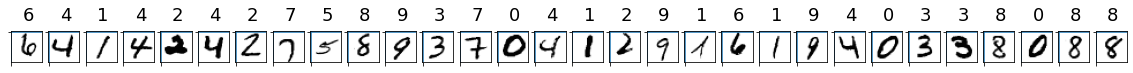

In [26]:
import json
import numpy as np

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=y_test[s], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

We can retrieve the API keys used for accessing the HTTP endpoint.

In [20]:
# Retrieve the API keys. Two keys were generated.
key1, Key2 = service.get_keys()
print(key1)

zVCdLbcw54f7UjaSqJgje7Huxop60022


We can now send construct raw HTTP request and send to the service. Don't forget to add key to the HTTP header.

In [21]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://53e197f5-c5d6-4128-a100-6f527a83562c.westus2.azurecontainer.io/score
label: 8
prediction: [8]


Let's look at the workspace after the web service was deployed. You should see 
* a registered model named 'keras-mlp-mnist' and with the id 'model:1'  
* a webservice called 'keras-mnist-svc' with some scoring URL

In [ ]:
models = ws.models
for name, model in models.items():
    print("Model: {}, ID: {}".format(name, model.id))


In [30]:
from azureml.core.compute.aks import AksCompute
from azureml.core.compute import ComputeTarget


# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration(agent_count = 4, vm_size = 'Standard_D3_v2', cluster_purpose = AksCompute.ClusterPurpose.FAST_PROD)

aks_name = 'aks-mnist' 
# Create the cluster
aks_target = ComputeTarget.create(workspace = ws, 
                                  name = aks_name, 
                                  provisioning_configuration = prov_config)



In [32]:
aks_target.wait_for_completion(True)

Creating.....................................................
SucceededProvisioning operation finished, operation "Succeeded"


In [5]:
from azureml.core.compute import ComputeTarget
aks_target = ComputeTarget(ws,'aks-mnist')

In [7]:
from azureml.core.model import Model
model = Model(ws,'keras-mlp-mnist')

In [9]:
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

In [10]:
from azureml.core.webservice import AksWebservice
aks_config = AksWebservice.deploy_configuration(auth_enabled=True,autoscale_enabled=True,enable_app_insights=True,collect_model_data=True)

In [11]:
%%time
aks_service_name ='aks-service-mnist'

aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

Running........................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 311 ms, sys: 45.1 ms, total: 356 ms
Wall time: 2min 28s


In [14]:
from azureml.core.webservice import AksWebservice
aks_service = AksWebservice(ws,'aks-service-mnist')

In [15]:
aks_service.scoring_uri

'http://52.175.205.201:80/api/v1/service/aks-service-mnist/score'

In [17]:
aks_service.get_keys()

('Xy5PFa6C5QJ0G8q3Nrnopgw7h8gJT5Ma', '7UnbjQWX17kepEib08zu1IHfSciiVAtA')

In [27]:
key1 = aks_service.get_keys()[0]

In [30]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

resp = requests.post(aks_service.scoring_uri, input_data, headers=headers)

print("POST to url", aks_service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)


POST to url http://52.175.205.201:80/api/v1/service/aks-service-mnist/score
label: 2
prediction: [2]


In [32]:
aks_service.update(autoscale_enabled=True,autoscale_max_replicas=20)

## Clean up
You can delete the ACI deployment with a simple delete API call.

In [ ]:
service.delete()

In [ ]:
aks_service.delete()